In [144]:
#Librerias Julia
using RCall
using PhyloNetworks
using PhyloPlots
using DataFrames
using Random
using Plots
using TSne
using Statistics
using Distances
using Clustering

In [3]:
#Librerias de R

R"""
library("ape")
library("phangorn")
library("ggtree")       # For phylogenetic tree visualization
library("ggplot2")      # For plotting
library("gridExtra")    # For organizing plots in a grid
"""

┌ Warning: RCall.jl: Warning: package 'phangorn' was built under R version 4.4.1
└ @ RCall C:\Users\Israel\.julia\packages\RCall\dDAVd\src\io.jl:172
┌ Warning: RCall.jl: ggtree v3.12.0 For help: https://yulab-smu.top/treedata-book/
│ 
│ If you use the ggtree package suite in published research, please cite
│ the appropriate paper(s):
│ 
│ Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
│ ggtree: an R package for visualization and annotation of phylogenetic
│ trees with their covariates and other associated data. Methods in
│ Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628
│ 
│ Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
│ Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
│ 
│ Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
│ for mapping and visualizing associated data on phylogeny using ggtree.
│ Molecular Biology and Evolution. 2018, 35(12):3041-3043.
│ doi:10.1093/molbev

RObject{StrSxp}
 [1] "gridExtra" "ggplot2"   "ggtree"    "phangorn"  "ape"       "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     


In [4]:
# Cargar dataset - Input
R"""
datos_dna <- read.dna("datasets/primates_14.phylip")
"""

RObject{RCall.RawSxp}
14 DNA sequences in binary format stored in a matrix.

All sequences of same length: 232 

Labels:
Mouse
Bovine
Lemur
Tarsier
Squir_Mon
Jpn_Macaq
...

Base composition:
    a     c     g     t 
0.375 0.402 0.039 0.184 
(Total: 3.25 kb)


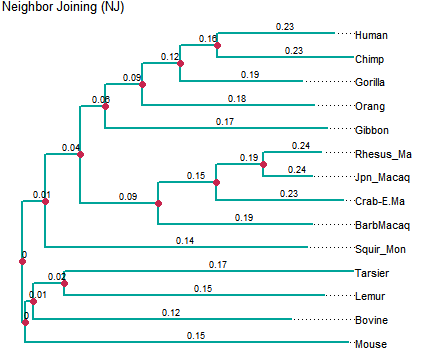

RObject{VecSxp}
TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]


In [5]:
R"""
# Convert the multiple sequence alignment result to a phyDat object for downstream analyses in phangorn
phyDat_msa_primate_sample = as.phyDat(datos_dna)

# Distance Calculation
# Calculate the Hamming distance matrix for the given aligned sequences
# This serves as a measure of pairwise sequence dissimilarity for tree construction
D_hamming = dist.hamming(phyDat_msa_primate_sample)

# Compute the Neighbor Joining tree
nj_tree = nj(D_hamming) #Aplica nj
nj_tree$edge.length[which(nj_tree$edge.length<0)]= 1 #Reemplaza los edges donde sea menor a cero por 1
# midpoint Re-root the tree at its midpoint for better visualization
# multi2di Binariza los arboles, o sea hace que de 1 padre salgan solo 2 hijos
nj_tree = midpoint(multi2di(nj_tree)) 


# Function to plot trees
plot_tree = function(tree_plot, title_plot, max_x) {
  g = ggtree(tree_plot, color = "#00A499", size = 1)
  
  # Customize the appearance of the plot and tip labels
  g = g + geom_tiplab(size = 4, color = "black", align = TRUE) +
    geom_nodepoint(size = 3, color = "#c7254e") +
    labs(title = title_plot, size = 6) +
    xlim(0, max_x) +
    theme(
      # Remove axis lines and text
      axis.line = element_blank(),
      axis.text = element_blank(),
      # Remove all grids
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      # Adjust margins and legend position
      plot.margin = margin(t = 0, r = -5, b = 0, l = 0, unit = "pt"),
      legend.position = 'top'
    )
  
  # Add labels for branch lengths with a smaller font size
  g = g + geom_text(aes(x = branch, label = round(branch, 2)), size = 3, color = "black", vjust = -0.5, hjust = 0)
  
  return(g)
}

# Create plots for the NJ tree
# Specify titles for each plot
g_NJ  = plot_tree(nj_tree, "Neighbor Joining (NJ)", 0.35)

# Organize the two plots in a one-row, two-column grid
grid.arrange(g_NJ, nrow = 1, ncol = 1)
"""

In [6]:
#Generar 100 arboles con NNI
R"""
# Se generan 100 arboles usando NNI con un solo movimiento de 1 rama
multiarboles = rNNI(nj_tree, moves = 1, n = 100)
"""

RObject{VecSxp}
100 phylogenetic trees


In [7]:
R"""
# Se asegura que estos arboles sean binarios, en caso no lo sean se binarizan
for (i in seq_along(multiarboles)) {
    # Verifica si el arbol en la posicion i no es binario
    if (!is.binary(multiarboles[[i]])) {
      # Si no es binario lo reemplaza con la version binarizada
      multiarboles[[i]] = multi2di(multiarboles[[i]])
    }
  }
"""

RObject{NilSxp}
NULL


In [8]:
# Se escribe el archivo resultante en formato newick
R"""
# Saving to Newick
write.tree(multiarboles, file="100-nj-initial.nwk")
"""

RObject{NilSxp}
NULL


In [9]:
#Una vez esto listo se generara un arbol de consenso para entrada para snaq de PhyloNetworks
R"""
# Arbol Medioide consenso
# Initialize an empty matrix for RF distances with dimensions 100x100
RF_distance_matrix = matrix(0, 100, 100)

# Calculate Robinson-Foulds (RF) distances between all pairs of trees 
for (a in 1:100) {
  for (b in 1:100) {
    # Calculate the RF distance between tree 'a' and tree 'b' and store it in the matrix
    RF_distance_matrix[a, b] = RF.dist(multiarboles[[a]], multiarboles[[b]], normalize = TRUE)
  }
}

# Find the index of the tree that minimizes the average RF distance
idx_med = which.min(colMeans(RF_distance_matrix))

# Medoid: Select the tree that corresponds to the medoid index
medoid_tree = multiarboles[[idx_med]]
#Reemplaza los edges donde sea menor a cero por 1
#medoid_tree$edge.length[which(medoid_tree$edge.length<=0)]= 1 
medoid_tree = midpoint(medoid_tree)
# Se verifica si es binario
print("Binario:")
print(is.binary(medoid_tree))
"""

[1] "Binario:"
[1] TRUE


RObject{LglSxp}
[1] TRUE


In [10]:
# Se guarda el arbol de consenso
R"""
# Saving to Newick
write.tree(medoid_tree, file="arbol-consenso-inicial.nwk")
"""

RObject{NilSxp}
NULL


## Aca hacia abajo empieza el proceso de SNAQ

In [11]:
#Julia
# Se leen los CF (Factores de Concordancia) de los 100 arboles generados
datacf = readTrees2CF("100-nj-initial.nwk")

will use all quartets on 14 taxa
calculating obsCF from 100 gene trees and for 1001 quartets
Reading in quartets...
0+--------------------------------------------------+100%  
  ****************************************  
table of obsCF printed to file tableCF.txt
descriptive stat of input data printed to file summaryTreesQuartets.txt


Object DataCF
number of quartets: 1001
number of trees: 100


In [12]:
# Se lee el arbol de consenso que se usara como punto inicial para snaq!
initialTree = readTopology("arbol-consenso-inicial.nwk")

HybridNetwork, Rooted Network
26 edges
27 nodes: 14 tips, 0 hybrid nodes, 13 internal tree nodes.
tip labels: Chimp, Human, Gorilla, Orang, ...
(((((((Chimp:0.12,Human:0.104):0.033,Gorilla:0.109):0.034,Orang:0.153):0.032,Gibbon:0.197):0.023,(((Jpn_Macaq:0.043,Rhesus_Ma:0.051):0.042,Crab-E.Ma:0.113):0.051,BarbMacaq:0.136):0.07):0.031,Squir_Mon:0.233):0.019,(((Lemur:0.231,Tarsier:0.256):0.028,Bovine:0.229):0.007,Mouse:0.289):0.001);


In [13]:
phylonetwork = snaq!(initialTree, datacf, hmax=1, runs=1, filename="phylonetwork")
#Para dejar de referencia, con los parametros que estan ahi con hmax=1 y runs=1 se demoro 55 minutos en correr

optimization of topology, BL and inheritance probabilities using:
 hmax = 1,
 tolerance parameters: ftolRel=1.0e-6, ftolAbs=1.0e-6,
                       xtolAbs=0.001, xtolRel=0.01.
 max number of failed proposals = 75, liktolAbs = 1.0e-6.
rootname for files: phylonetwork
BEGIN: 1 runs on starting tree (Chimp,Human,(Gorilla,(Orang,(Gibbon,((((Jpn_Macaq,Rhesus_Ma):0.04212382445,Crab-E.Ma):0.05100574713,BarbMacaq):0.06996228448,(Squir_Mon,(((Lemur,Tarsier):0.02777310075,Bovine):0.006659146013,Mouse):0.01870892905):0.03087957974):0.02271012931):0.03237248563):0.03371305419):0.03347252155);
2024-10-06 19:18:51.782
seed: 31822 for run 1, 2024-10-06 19:18:53.622
best network and networks with different hybrid/gene flow directions printed to .networks file

MaxNet is (Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.0404313920703765,BarbMacaq):0.7435551393691957,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.631514612920511):0.6623373265490394):0.6461697286275412)#H17:0.0::0.8504746

HybridNetwork, Un-rooted Network
28 edges
28 nodes: 14 tips, 1 hybrid nodes, 13 internal tree nodes.
tip labels: Chimp, Human, Gorilla, Orang, ...
(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.04,BarbMacaq):0.744,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.632):0.662):0.646)#H17:0.0::0.85):0.0,Bovine):0.489):3.587,(Gibbon,#H17:3.501::0.15):0.0):2.13):2.489):1.566);


In [ ]:
#(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.04,BarbMacaq):0.744,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.632):0.662):0.646)#H17:0.0::0.85):0.0,Bovine):0.489):3.587,(Gibbon,#H17:3.501::0.15):0.0):2.13):2.489):1.566);

In [106]:
#Se carga la red conseguida
network = readTopology("(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.0404313920703765,BarbMacaq):0.7435551393691957,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.631514612920511):0.6623373265490394):0.6461697286275412)#H17:0.0::0.8504746823085855):2.3377630939063185e-7,Bovine):0.48924458319757164):3.58679376267071,(Gibbon,#H17:3.5005007477360706::0.14952531769141453):0.0):2.1304287910826285):2.4888147361808226):1.5656090423495401);")

HybridNetwork, Rooted Network
28 edges
28 nodes: 14 tips, 1 hybrid nodes, 13 internal tree nodes.
tip labels: Chimp, Human, Gorilla, Orang, ...
(Chimp,Human,(Gorilla,(Orang,((((Jpn_Macaq,Rhesus_Ma):3.04,BarbMacaq):0.744,((Crab-E.Ma,((Squir_Mon,(Mouse,(Lemur,Tarsier):2.632):0.662):0.646)#H17:0.0::0.85):0.0,Bovine):0.489):3.587,(Gibbon,#H17:3.501::0.15):0.0):2.13):2.489):1.566);


In [ ]:
# Se guarda la red conseguida
writeTopology(network, "phylonet.nwk")

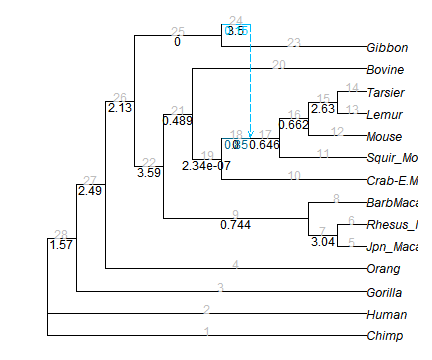

In [107]:
R"par"(mar = [0,0,0,1]);
PhyloPlots.plot(network, showgamma=true, showedgelength=true, showedgenumber=true);

In [108]:
printEdges(network)

edge parent child  length  hybrid isMajor gamma   containRoot inCycle istIdentitiable
1    -2     1              false  true    1       true        -1      false
2    -2     2              false  true    1       true        -1      false
3    -3     3              false  true    1       true        -1      false
4    -4     4              false  true    1       true        -1      false
5    -8     5              false  true    1       true        -1      false
6    -8     6              false  true    1       true        -1      false
7    -7     -8     3.040   false  true    1       true        -1      true 
8    -7     7              false  true    1       true        -1      false
9    -6     -7     0.744   false  true    1       true        -1      true 
10   -10    8              false  true    1       true        -1      false
11   -12    9              false  true    1       false       -1      false
12   -13    10             false  true    1       false       -1      false
13

In [39]:
#network.edge[1].length

-1.0

In [36]:
#size(network.edge)[1]

28

In [45]:
#network.edge

28-element Vector{PhyloNetworks.EdgeT{PhyloNetworks.Node}}:
 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:1
 length:-1.0
 attached to 2 node(s) (parent first): -2 1

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:2
 length:-1.0
 attached to 2 node(s) (parent first): -2 2

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:3
 length:-1.0
 attached to 2 node(s) (parent first): -3 3

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:4
 length:-1.0
 attached to 2 node(s) (parent first): -4 4

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:5
 length:-1.0
 attached to 2 node(s) (parent first): -8 5

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:6
 length:-1.0
 attached to 2 node(s) (parent first): -8 6

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:7
 length:3.0404313920703765
 attached to 2 node(s) (parent first): -7 -8

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 number:8
 length:-1.0
 attached to 2 node(s) (parent first): -7 7

 PhyloNetworks.EdgeT{PhyloNetworks.Node}:
 nu

In [65]:
# Arreglar el largo perdido en los edges
for e in network.edge
    if e.length <= 0
        e.length = 1
    end
end

In [61]:
# Se guarda la red conseguida una vez arreglada
writeTopology(network, "phylonet-fixed.nwk")

In [62]:
#Arreglar la estructura del arbol - binarizarla
R"""
phylored = read.tree("phylonet-fixed.nwk")
phylored = midpoint(multi2di(phylored))
write.tree(phylored, file="red_filo_binaria.nwk")
"""

RObject{NilSxp}
NULL


In [70]:
phylonet = readTopology("red_filo_binaria.nwk")

HybridNetwork, Rooted Network
28 edges
28 nodes: 14 tips, 1 hybrid nodes, 13 internal tree nodes.
tip labels: Lemur, Tarsier, Mouse, Squir_Mon, ...
(((((((Lemur:1.0,Tarsier:1.0):2.632,Mouse:1.0):0.662,Squir_Mon:1.0)#H17:1.646,Crab-E.Ma:1.0):0.0,Bovine:1.0):0.489,((Jpn_Macaq:1.0,Rhesus_Ma:1.0):3.04,BarbMacaq:1.0):0.744):2.171,((((Human:1.0,Chimp:1.0):1.566,Gorilla:1.0):2.489,Orang:1.0):2.13,(Gibbon:1.0,#H17:3.501):1.0):1.416);


In [69]:
# Arreglar el largo perdido en los edges
for e in phylonet.edge
    if e.length <= 0
        e.length = 1
    end
end

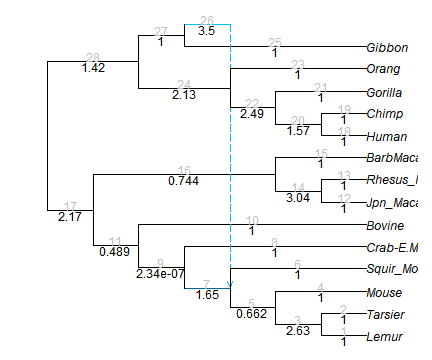

In [71]:
R"par"(mar = [0,0,0,1]);
PhyloPlots.plot(phylonet, showgamma=true, showedgelength=true, showedgenumber=true);

# Una vez conseguida y arreglada la red inicial - se procede a efectuar:
# NNI para conseguir 100 redes filogeneticas distintas - Calcular parsimonia y verosimilitud
# Armar frente de pareto

In [ ]:
# Utilitario para convertir phylip a fasta para rapidamente conseguir los elementos que se necesitan
#R"""
#datos_dna = read.dna("archivo.phylip")
#write.FASTA(datos_dna,"archivo.fasta")
#"""

In [74]:
species, traits = PhyloNetworks.readFastaToArray("datasets/primates_14.fasta")

(["Mouse", "Bovine", "Lemur", "Tarsier", "Squir_Mon", "Jpn_Macaq", "Rhesus_Ma", "Crab-E.Ma", "BarbMacaq", "Gibbon", "Orang", "Gorilla", "Chimp", "Human"], BioSequences.BioSequence[ACCAAAAAAACATCCAAACACCAACCCCAGCCCTTACGC…ACCCTTCCACAAATCCTTAATATACGCACCATAAATAAC, ACCAAACCTGTCCCCACCATCTAACACCAACCCACATAT…ACCCTCCATCAAATCCACAAATTACACAACCATTAACCC, ACCAAACTAACATCTAACAACTACCTCCAACTCTAAAAA…ATCCCTCCCATAATCCAAAAACTCCATAAACACAAATTC, ATCTACCTTATCTCCCCCAATCAATACCAACCTAAAAAC…CCATAACACAGCATACATAAACTCCATAAGTTTGAACAC, ACCCCAGCAACTCGTTGTGACCAACATCAATCCAAAATT…CCCCTCTCATAACTCTACAAAATACACAATCACCAACAC, ACTCCACCTGCTCACCTCATCCACTACTACTCCTCAAGC…ATTCCCCCCAATACCCACAAACTGCATAAGCAAACAGAC, ACTTCACCCGTTCACCTCATCCACTACTACTCCTCAAGC…ATTCCCCCCAATACCCACAAACTACATAAACAAACAAAC, ACCCCACCTACCCGCCTCGTCCGCTACTGCTTCTCAAAC…ATTTTCTCCAACACCCACAAACTGTATAAACAAACAAAC, ACCCTATCTATCTACCTCACCCGCCACCACCCCCCAAAC…ATTCTCCCTAATATACACAAACCACGCAAACAAACAAAC, ACTATACCCACCCAACTCGACCTACACCAATCCCCACAT…CTCTACCATCAAACGCACAACTTACACATACAGAACCAC, ACCCCACCCG

In [75]:
species

14-element Vector{String}:
 "Mouse"
 "Bovine"
 "Lemur"
 "Tarsier"
 "Squir_Mon"
 "Jpn_Macaq"
 "Rhesus_Ma"
 "Crab-E.Ma"
 "BarbMacaq"
 "Gibbon"
 "Orang"
 "Gorilla"
 "Chimp"
 "Human"

In [83]:
traits

14-element Vector{BioSequences.BioSequence}:
 ACCAAAAAAACATCCAAACACCAACCCCAGCCCTTACGC…ACCCTTCCACAAATCCTTAATATACGCACCATAAATAAC
 ACCAAACCTGTCCCCACCATCTAACACCAACCCACATAT…ACCCTCCATCAAATCCACAAATTACACAACCATTAACCC
 ACCAAACTAACATCTAACAACTACCTCCAACTCTAAAAA…ATCCCTCCCATAATCCAAAAACTCCATAAACACAAATTC
 ATCTACCTTATCTCCCCCAATCAATACCAACCTAAAAAC…CCATAACACAGCATACATAAACTCCATAAGTTTGAACAC
 ACCCCAGCAACTCGTTGTGACCAACATCAATCCAAAATT…CCCCTCTCATAACTCTACAAAATACACAATCACCAACAC
 ACTCCACCTGCTCACCTCATCCACTACTACTCCTCAAGC…ATTCCCCCCAATACCCACAAACTGCATAAGCAAACAGAC
 ACTTCACCCGTTCACCTCATCCACTACTACTCCTCAAGC…ATTCCCCCCAATACCCACAAACTACATAAACAAACAAAC
 ACCCCACCTACCCGCCTCGTCCGCTACTGCTTCTCAAAC…ATTTTCTCCAACACCCACAAACTGTATAAACAAACAAAC
 ACCCTATCTATCTACCTCACCCGCCACCACCCCCCAAAC…ATTCTCCCTAATATACACAAACCACGCAAACAAACAAAC
 ACTATACCCACCCAACTCGACCTACACCAATCCCCACAT…CTCTACCATCAAACGCACAACTTACACATACAGAACCAC
 ACCCCACCCGTCTACACCAGCCAACACCAACCCCCACCT…ACCTTCCTCAAAATCCAAAACCCACACAACCGAAACAAC
 ACCCCATTTATCCATAAAAACCAACACCAACCCCCATCT…ACCTCCCCCCAAATACACAATTC

In [99]:
dna_dat, dna_weights = PhyloNetworks.readfastatodna("datasets/primates_14.fasta", false)

(14×233 DataFrame
 Row │ taxon      x1   x2   x3   x4   x5   x6   x7   x8   x9   x10  x11  x12   ⋯
     │ String     DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA  DNA   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Mouse      A    C    C    A    A    A    A    A    A    A    C    A     ⋯
   2 │ Bovine     A    C    C    A    A    A    C    C    T    G    T    C
   3 │ Lemur      A    C    C    A    A    A    C    T    A    A    C    A
   4 │ Tarsier    A    T    C    T    A    C    C    T    T    A    T    C
   5 │ Squir_Mon  A    C    C    C    C    A    G    C    A    A    C    T     ⋯
   6 │ Jpn_Macaq  A    C    T    C    C    A    C    C    T    G    C    T
   7 │ Rhesus_Ma  A    C    T    T    C    A    C    C    C    G    T    T
   8 │ Crab-E.Ma  A    C    C    C    C    A    C    C    T    A    C    C
   9 │ BarbMacaq  A    C    C    C    T    A    T    C    T    A    T    C     ⋯
  10 │ Gibbon     A    C    T    A    T    A  

In [100]:
dna_weights

232-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [101]:
mJC69 = JC69([0.25], false);

In [102]:
mJC69

Jukes and Cantor 69 Substitution Model,
absolute rate version
off-diagonal rates equal to 0.25/3.
rate matrix Q:
               A       C       G       T
       A       *  0.0833  0.0833  0.0833
       C  0.0833       *  0.0833  0.0833
       G  0.0833  0.0833       *  0.0833
       T  0.0833  0.0833  0.0833       *

In [105]:
printEdges(phylonet)

edge parent child  length  hybrid isMajor gamma   containRoot inCycle istIdentitiable
1    -8     1      1.000   false  true    1       false       -1      false
2    -8     2      1.000   false  true    1       false       -1      false
3    -7     -8     2.632   false  true    1       false       -1      true 
4    -7     3      1.000   false  true    1       false       -1      false
5    5      -7     0.662   false  true    1       false       -1      true 
6    5      4      1.000   false  true    1       false       -1      false
7    -5     5      1.646   true   true            true        -1      true 
8    -5     6      1.000   false  true    1       true        -1      false
9    -4     -5     0.000   false  true    1       true        -1      true 
10   -4     7      1.000   false  true    1       true        -1      false
11   -3     -4     0.489   false  true    1       true        -1      true 
12   -10    8      1.000   false  true    1       true        -1      false
13

In [109]:
setGamma!(phylonet.edge[7], 0.8505)

In [110]:
setGamma!(phylonet.edge[26], 0.1495)

In [111]:
printEdges(phylonet)

edge parent child  length  hybrid isMajor gamma   containRoot inCycle istIdentitiable
1    -8     1      1.000   false  true    1       false       -1      false
2    -8     2      1.000   false  true    1       false       -1      false
3    -7     -8     2.632   false  true    1       false       -1      true 
4    -7     3      1.000   false  true    1       false       -1      false
5    5      -7     0.662   false  true    1       false       -1      true 
6    5      4      1.000   false  true    1       false       -1      false
7    -5     5      1.646   true   true    0.8505  true        -1      true 
8    -5     6      1.000   false  true    1       true        -1      false
9    -4     -5     0.000   false  true    1       true        -1      true 
10   -4     7      1.000   false  true    1       true        -1      false
11   -3     -4     0.489   false  true    1       true        -1      true 
12   -10    8      1.000   false  true    1       true        -1      false
13

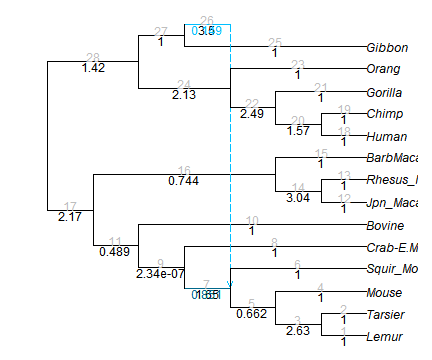

In [112]:
R"par"(mar = [0,0,0,1]);
PhyloPlots.plot(phylonet, showgamma=true, showedgelength=true, showedgenumber=true);

In [114]:
# Calcula verosimilitud
d1 = fitdiscrete(phylonet, mJC69, dna_dat, dna_weights)

PhyloNetworks.StatisticalSubstitutionModel:
Jukes and Cantor 69 Substitution Model,
  absolute rate version
  off-diagonal rates equal to 0.13127/3.
  rate matrix Q:
                 A       C       G       T
         A       *  0.0438  0.0438  0.0438
         C  0.0438       *  0.0438  0.0438
         G  0.0438  0.0438       *  0.0438
         T  0.0438  0.0438  0.0438       *
on a network with 1 reticulations
data:
  14 species
  232 sites
log-likelihood: -3370.22424

In [117]:
d1.loglik

-3370.2242435869525

In [115]:
# Calcula parsimonia
parsimonySoftwired(phylonet, species, traits)

777.0

In [120]:
#Printear cantidad de ramas - edges
edgenumber = size(phylonet.edge)[1]

28

In [121]:
edgenumber

28

In [86]:
originalInitialNetwork = deepcopy(phylonet)

HybridNetwork, Rooted Network
28 edges
28 nodes: 14 tips, 1 hybrid nodes, 13 internal tree nodes.
tip labels: Lemur, Tarsier, Mouse, Squir_Mon, ...
(((((((Lemur:1.0,Tarsier:1.0):2.632,Mouse:1.0):0.662,Squir_Mon:1.0)#H17:1.646,Crab-E.Ma:1.0):0.0,Bovine:1.0):0.489,((Jpn_Macaq:1.0,Rhesus_Ma:1.0):3.04,BarbMacaq:1.0):0.744):2.171,((((Human:1.0,Chimp:1.0):1.566,Gorilla:1.0):2.489,Orang:1.0):2.13,(Gibbon:1.0,#H17:3.501):1.0):1.416);


In [135]:
parsimonyScores = []
pseudolikelihoods = []
generatedNetworks = []
networksLabel = []

for i in 1:100
    #Hacer nni
    rnd = rand(1:edgenumber)
    nni!(phylonet, phylonet.edge[rnd], true, true);
    #println(phylonet)
    
    # Hacer copia de la red generada
    auxnet = deepcopy(phylonet)

    # Calcular parsimonia de la nueva red
    parsimonyScore = parsimonySoftwired(phylonet, species, traits)

    # Calcular pseudolikelihood de la nueva red
    fit1 = fitdiscrete(phylonet, mJC69, dna_dat, dna_weights)
    pseudoLikelihood = fit1.loglik

    # Guardar etiqueta de la red
    push!(networksLabel, "Network $i")
    
    # Guardar resultados
    push!(generatedNetworks, auxnet)
    push!(parsimonyScores, parsimonyScore)
    push!(pseudolikelihoods, pseudoLikelihood)
end

In [136]:
parsimonyScores

100-element Vector{Any}:
 813.0
 809.0
 809.0
 809.0
 813.0
 812.0
 810.0
 810.0
 810.0
 810.0
 811.0
 811.0
 811.0
   ⋮
 812.0
 813.0
 812.0
 812.0
 812.0
 811.0
 811.0
 811.0
 807.0
 807.0
 807.0
 807.0

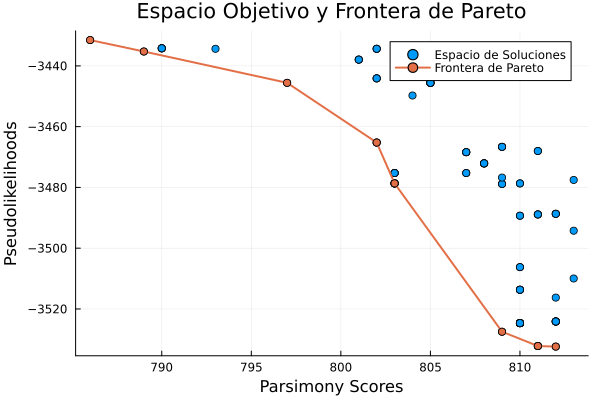

In [142]:
# Crear un DataFrame con los datos, incluyendo las redes generadas
df_plot = DataFrame(parsimonyScores = parsimonyScores, pseudolikelihoods = pseudolikelihoods, networksLabel = networksLabel)

# Ordenar por parsimonyScores y luego por pseudolikelihoods
sort!(df_plot, [:parsimonyScores, :pseudolikelihoods])

# Encontrar la frontera de Pareto minimizando ambas métricas
pareto_front = DataFrame(parsimonyScores = Int[], pseudolikelihoods = Float64[], networksLabel = String[])
min_likelihood = Inf
for row in eachrow(df_plot)
    if row.pseudolikelihoods < min_likelihood
        push!(pareto_front, row)
        min_likelihood = row.pseudolikelihoods
    end
end

# Graficar los puntos y la frontera de Pareto
Plots.scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Espacio de Soluciones", legend = :topright)
Plots.plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, marker = :circle)

xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo y Frontera de Pareto")

In [139]:
# Mostrar las redes generadas en la frontera de Pareto
println("Redes en la frontera de Pareto:")
println(pareto_front.networksLabel)

Redes en la frontera de Pareto:
["Network 46", "Network 51", "Network 69", "Network 67", "Network 52", "Network 26", "Network 11", "Network 27"]


In [141]:
pareto_front

Row,parsimonyScores,pseudolikelihoods,networksLabel
,Int64,Float64,String
1,786,-3431.5,Network 46
2,789,-3435.27,Network 51
3,797,-3445.58,Network 69
4,802,-3465.23,Network 67
5,803,-3478.67,Network 52
6,809,-3527.49,Network 26
7,811,-3532.2,Network 11
8,812,-3532.39,Network 27


# Listo el espacio objetivo

# Ahora toca armar el espacio de decision

In [145]:
function calculate_distance_matrix(generatedNetworks, flag=true)
    num_networks = length(generatedNetworks)
    distance_matrix = zeros(Float64, num_networks, num_networks)

    for i in 1:num_networks
        for j in i+1:num_networks
            distance = hardwiredClusterDistance(generatedNetworks[i], generatedNetworks[j], flag)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Matriz simétrica
        end
    end

    return distance_matrix
end


calculate_distance_matrix (generic function with 2 methods)

In [146]:
matriz_distancia = calculate_distance_matrix(generatedNetworks)

100×100 Matrix{Float64}:
  0.0   2.0   4.0   4.0   6.0   8.0  …  14.0  14.0  14.0  14.0  14.0  14.0
  2.0   0.0   2.0   2.0   4.0   6.0     16.0  16.0  16.0  16.0  16.0  16.0
  4.0   2.0   0.0   0.0   2.0   4.0     14.0  14.0  16.0  16.0  16.0  16.0
  4.0   2.0   0.0   0.0   2.0   4.0     14.0  14.0  16.0  16.0  16.0  16.0
  6.0   4.0   2.0   2.0   0.0   2.0     16.0  16.0  18.0  18.0  18.0  18.0
  8.0   6.0   4.0   4.0   2.0   0.0  …  16.0  16.0  18.0  18.0  18.0  18.0
 10.0   8.0   6.0   6.0   4.0   2.0     14.0  14.0  16.0  16.0  16.0  16.0
 10.0   8.0   6.0   6.0   4.0   2.0     14.0  14.0  16.0  16.0  16.0  16.0
 10.0   8.0   6.0   6.0   4.0   2.0     14.0  14.0  16.0  16.0  16.0  16.0
 10.0   8.0   6.0   6.0   4.0   2.0     14.0  14.0  16.0  16.0  16.0  16.0
 12.0  10.0   8.0   8.0   6.0   4.0  …  14.0  14.0  16.0  16.0  16.0  16.0
 12.0  10.0   8.0   8.0   6.0   4.0     14.0  14.0  16.0  16.0  16.0  16.0
 12.0  10.0   8.0   8.0   6.0   4.0     14.0  14.0  16.0  16.0  16.0  16.0


In [147]:
# Función para aplicar t-SNE a la matriz de distancia
function apply_tsne(distance_matrix; dims=2, perplexity=30.0)
    max_iter = 1000
    reduce_dims = 0
    tsne_result = tsne(distance_matrix, dims, reduce_dims, max_iter, perplexity; distance=true)
    return tsne_result
end

apply_tsne (generic function with 1 method)

In [149]:
# Aplicar t-SNE a la matriz de distancia
tsne_result = apply_tsne(matriz_distancia)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\Israel\.julia\packages\ProgressMeter\dMfiC\src\ProgressMeter.jl:594
Computing t-SNE 100%|████████████████████████████████████| Time: 0:00:00
  KL_divergence:  0.2771


100×2 Matrix{Float64}:
 -44.8776     9.94769
 -41.237     13.9463
  -5.28999   31.7677
 -47.1621    15.8516
 -42.6138    20.5981
 -48.9238    22.935
 -45.4076    27.7586
 -49.5698    30.8403
 -53.9821    27.6996
 -40.1512    29.1472
 -44.1171    34.4499
 -55.3018    35.2704
 -49.4793    36.5347
   ⋮        
  44.1765   -51.9682
  49.8389   -48.515
  54.6801   -45.2702
  51.2295   -54.7597
  58.4888   -39.99
  61.3443   -51.2115
  56.124    -51.2233
  60.4807   -45.9289
  58.651    -57.2867
  67.2186   -49.6555
  65.0146   -55.8275
  65.9092   -43.5187

In [150]:
# Calcular el coeficiente de silueta para diferentes valores de k
function calculate_silhouette_scores(data_matrix, max_k)
    silhouette_scores = Float64[]
    for k in 2:max_k
        result = kmeans(data_matrix, k)
        D = pairwise(SqEuclidean(), data_matrix, dims=2)
        score = mean(silhouettes(result.assignments, D))
        push!(silhouette_scores, score)
    end
    return silhouette_scores
end

calculate_silhouette_scores (generic function with 1 method)

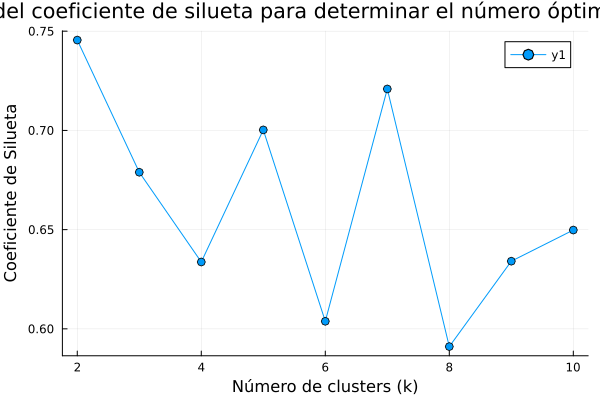

In [180]:
max_k = 10  # Podemos ajustar este valor según sea necesario
silhouette_scores = calculate_silhouette_scores(matriz_distancia, max_k)

# Graficar el coeficiente de silueta en función de k para encontrar el valor óptimo
Plots.plot(2:max_k, silhouette_scores, marker=:o, title="Método del coeficiente de silueta para determinar el número óptimo de clusters",
     xlabel="Número de clusters (k)", ylabel="Coeficiente de Silueta")

In [182]:
# Aplicar KMeans clustering con el número óptimo de clusters
# Seleccionar el número óptimo de clusters a partir del gráfico
optimal_k = argmax(silhouette_scores) + 1

result = kmeans(matriz_distancia, optimal_k)

# Paso 4: Visualización de los resultados en el espacio 2D original
# Aquí asumimos que la visualización será en función de los dos primeros índices de la matriz original
#Plot.scatter(data_matrix[:, 1], data_matrix[:, 2], group=result.assignments, 
#        legend=:top, title="Clustering con número óptimo de clusters", xlabel="Index 1", ylabel="Index 2")

# Mostrar las asignaciones de clusters
println("Número óptimo de clusters: ", optimal_k)
println("Asignaciones de clusters: ", result.assignments)

Número óptimo de clusters: 2
Asignaciones de clusters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [183]:
# Visualizar el resultado de t-SNE con los clusters
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters", xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

# Agregar una leyenda que indique los clusters
for i in 1:optimal_k
    scatter!(tsne_result[result.assignments .== i, 1], tsne_result[result.assignments .== i, 2], label="Cluster $i")
end

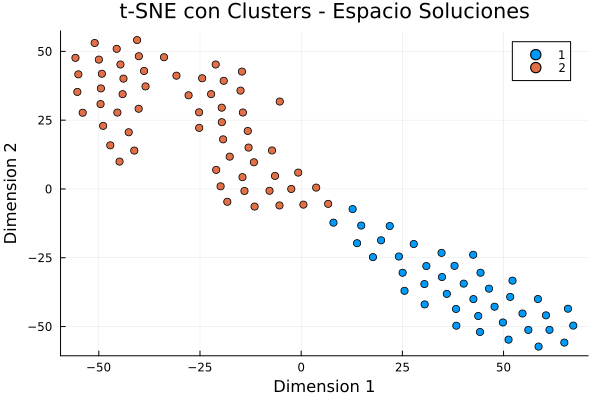

In [185]:
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters - Espacio Soluciones", xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

# Se repite lo mismo para el espacio objetivo, necesitamos clucksterizar para aplicar jaccard

In [186]:
# Ocupando distancia euclidiana se hace una matriz de distancia usando al mismo tiempo
# Parsimonia y verosimilitud

# Crear una matriz combinando los puntajes de parsimonia y verosimilitud
combined_scores = [parsimonyScores pseudolikelihoods]

# Calcular la matriz de distancia euclidiana
distance_matrix_euclidean = zeros(Float64, length(parsimonyScores), length(parsimonyScores))

for i in 1:length(parsimonyScores)
    for j in 1:length(parsimonyScores)
        distance_matrix_euclidean[i, j] = euclidean(combined_scores[i, :], combined_scores[j, :])
    end
end

# Para visualizar los resultados
println("Matriz de distancia euclidiana:")

Matriz de distancia euclidiana:


In [187]:
distance_matrix_euclidean

100×100 Matrix{Float64}:
  0.0       4.07525   4.21029   4.21029  …  10.9306   10.9306   10.9306
  4.07525   0.0       2.09349   2.09349      8.59313   8.59313   8.59313
  4.21029   2.09349   0.0       0.0         10.6403   10.6403   10.6403
  4.21029   2.09349   0.0       0.0         10.6403   10.6403   10.6403
 16.71     17.9411   15.9072   15.9072      26.5339   26.5339   26.5339
 38.7362   39.6166   37.5294   37.5294   …  48.1204   48.1204   48.1204
 36.2641   36.9329   34.8402   34.8402      45.3757   45.3757   45.3757
 36.2641   36.9329   34.8402   34.8402      45.3757   45.3757   45.3757
 36.2641   36.9329   34.8402   34.8402      45.3757   45.3757   45.3757
 36.2641   36.9329   34.8402   34.8402      45.3757   45.3757   45.3757
 54.6962   55.4752   53.3831   53.3831   …  63.9216   63.9216   63.9216
 54.6962   55.4752   53.3831   53.3831      63.9216   63.9216   63.9216
 54.6962   55.4752   53.3831   53.3831      63.9216   63.9216   63.9216
  ⋮                                   

In [188]:
# Se ocupa como hipotesis que los espacios son iguales, asi que la cantidad de clusters sera la misma aca

# Aplicar KMeans clustering con el número óptimo de clusters
# Seleccionar el número óptimo de clusters a partir del gráfico
#optimal_k_eo = argmax(silhouette_scores_eo) + 1
#optimal_k_eo = 7 # A la fuerza, borrar luego
result_eo = kmeans(distance_matrix_euclidean, optimal_k)

# Mostrar las asignaciones de clusters
println("Número óptimo de clusters: ", optimal_k)
println("Asignaciones de clusters: ", result_eo.assignments)

Número óptimo de clusters: 2
Asignaciones de clusters: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [192]:
result_eo_assignments = result_eo.assignments
result_assignments = result.assignments

100-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

# Vamos a ignorar el grafico aca, directo a jaccard

In [194]:
# Pasar los vectores de la asignacion de clusters a R 
@rput result_eo_assignments

100-element Vector{Int64}:
 1
 1
 1
 1
 1
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 2
 2
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [198]:
@rput result_assignments

100-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [199]:
# Ahora ambas variables pasaron a R
R"""
print(result_eo_assignments)
print(result_assignments)
"""

  [1] 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1
 [75] 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


RObject{IntSxp}
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


In [200]:
R"""
library("cluster")
library("clusteval") 
"""

RObject{StrSxp}
 [1] "clusteval" "cluster"   "gridExtra" "ggplot2"   "ggtree"    "phangorn" 
 [7] "ape"       "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"     


In [204]:
R"""
indice_jaccard = cluster_similarity(result_assignments, result_eo_assignments, similarity = "jaccard")
print(indice_jaccard)
"""

[1] 0.3651929


RObject{RealSxp}
[1] 0.3651929


In [203]:
R"""
print(class(indice_jaccard))
"""

[1] "numeric"


RObject{StrSxp}
[1] "numeric"


In [205]:
# Traer la variable  de R a Julia
@rget indice_jaccard

0.36519294658829543

In [206]:
print(indice_jaccard)

0.36519294658829543

# Finalmente el indice de Jaccard es de 0.36 para primates-14, significa que los espacios no son iguales

# Hacer grafico pulento

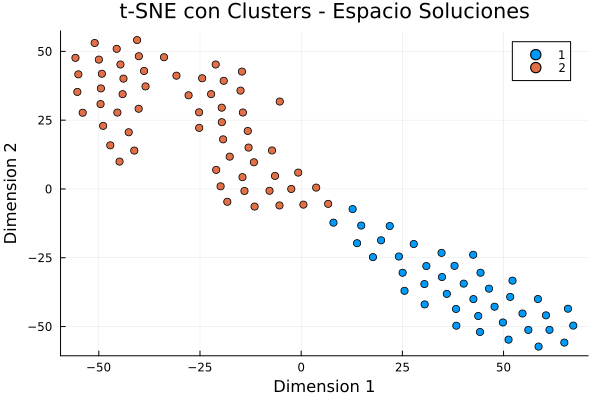

In [207]:
# Grafico del espacio de soluciones
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters - Espacio Soluciones", xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

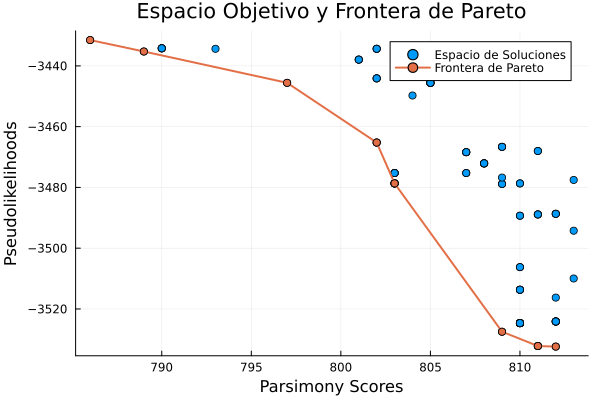

In [208]:
# Grafico del espacio objetivo

Plots.scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Espacio de Soluciones", legend = :topright)
Plots.plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, marker = :circle)

xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo y Frontera de Pareto")

In [211]:
# Mostrar las redes generadas en la frontera de Pareto
println("Redes en la frontera de Pareto:")
println(pareto_front.networksLabel)

Redes en la frontera de Pareto:
["Network 46", "Network 51", "Network 69", "Network 67", "Network 52", "Network 26", "Network 11", "Network 27"]


In [210]:
# Encontrar los índices de las redes en la frontera de Pareto en el arreglo original
pareto_indices = [findfirst(x -> x == label, networksLabel) for label in pareto_front.networksLabel]

# Esto te dará un array con los índices de las redes en la frontera de Pareto
println("Índices de las redes en la frontera de Pareto:")
println(pareto_indices)

Índices de las redes en la frontera de Pareto:
[46, 51, 69, 67, 52, 26, 11, 27]


In [225]:
pareto_front

Row,parsimonyScores,pseudolikelihoods,networksLabel
,Int64,Float64,String
1,786,-3431.5,Network 46
2,789,-3435.27,Network 51
3,797,-3445.58,Network 69
4,802,-3465.23,Network 67
5,803,-3478.67,Network 52
6,809,-3527.49,Network 26
7,811,-3532.2,Network 11
8,812,-3532.39,Network 27


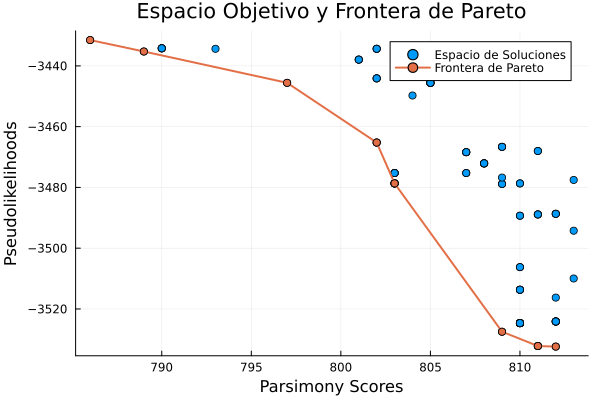

In [214]:
# Grafico del espacio objetivo

Plots.scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Espacio de Soluciones", legend = :topright)
Plots.plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, marker = :circle)

xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo y Frontera de Pareto")

In [227]:
# Lista de marcadores geométricos disponibles
markers = [:octagon, :utriangle, :star5, :diamond, :rect, :star8, :hexagon, :pentagon]

# Asignar un marcador a cada red en la frontera de Pareto
pareto_front[!, :marker] = markers[1:nrow(pareto_front)]  # Asegúrate de que haya suficientes marcadores

8-element Vector{Symbol}:
 :octagon
 :utriangle
 :star5
 :diamond
 :rect
 :star8
 :hexagon
 :pentagon

In [244]:
# Graficar el espacio objetivo (todas las redes)
scatter(df_plot.parsimonyScores, df_plot.pseudolikelihoods, label = "Espacio de Soluciones", legend = :topright)

# Graficar la línea de la frontera de Pareto con el color naranja
plot!(pareto_front.parsimonyScores, pareto_front.pseudolikelihoods, label = "Frontera de Pareto", lw = 2, color = :orange)

# Graficar los puntos de la frontera de Pareto con los marcadores asignados y color naranja
for i in 1:nrow(pareto_front)
    scatter!([pareto_front.parsimonyScores[i]], [pareto_front.pseudolikelihoods[i]], 
        marker = (pareto_front.marker[i], 10), label = "", color = :orange)  # Usamos naranja para los puntos
end

# Etiquetas y título
xlabel!("Parsimony Scores")
ylabel!("Pseudolikelihoods")
title!("Espacio Objetivo y Frontera de Pareto")

savefig("./graphs/espacio_objetivo_pareto.pdf")


"c:\\Users\\Israel\\Documents\\Codes\\Taller de investigación\\array-code\\array-code-definitivo\\graphs\\espacio_objetivo_pareto.pdf"

In [245]:
# Graficar el espacio de decisiones (t-SNE) con clusters
scatter(tsne_result[:, 1], tsne_result[:, 2], group=result.assignments, title="t-SNE con Clusters", 
    xlabel="Dimension 1", ylabel="Dimension 2", legend=:topright)

# Resaltar las redes en la frontera de Pareto con los mismos marcadores, usando pareto_indices
for i in 1:length(pareto_indices)
    idx = pareto_indices[i]  # Obtener el índice correspondiente de la frontera de Pareto
    scatter!([tsne_result[idx, 1]], [tsne_result[idx, 2]], 
        marker = (pareto_front.marker[i], 10), label = "", color = :orange)
end

savefig("./graphs/espacio_solucion_tsne.pdf")

"c:\\Users\\Israel\\Documents\\Codes\\Taller de investigación\\array-code\\array-code-definitivo\\graphs\\espacio_solucion_tsne.pdf"